In [ ]:
import pandas as pd
import zipfile
from google.colab import files
import io
import re
import nltk
from nltk.tokenize import word_tokenize

def clean_telugu_text(text):
    """Cleans Telugu text: removes special characters, extra spaces, and handles non-string values."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\u0C00-\u0C7F\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_clean_data():
    """Loads and cleans the Telugu sentiment dataset."""
    try:
        uploaded = files.upload()
        zip_filename = next(iter(uploaded))

        with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), 'r') as zip_ref:
            train_filename = 'Sentiment_train.csv'
            test_filename = 'Sentiment_test.csv'
            validation_filename = 'Sentiment_valid%20.csv'

            try:
                with zip_ref.open(train_filename) as train_file:
                    train_df = pd.read_csv(train_file)
                print(f"Loaded '{train_filename}'")

                with zip_ref.open(test_filename) as test_file:
                    test_df = pd.read_csv(test_file)
                print(f"\nLoaded '{test_filename}'")

                with zip_ref.open(validation_filename) as validation_file:
                    validation_df = pd.read_csv(validation_file)
                print(f"\nLoaded '{validation_filename}'")

                train_df['Sentence'] = train_df['Sentence'].apply(clean_telugu_text)
                test_df['Sentence'] = test_df['Sentence'].apply(clean_telugu_text)
                validation_df['Sentence'] = validation_df['Sentence'].apply(clean_telugu_text)

                train_df = train_df.drop('Unnamed: 0', axis=1)
                test_df = test_df.drop('Unnamed: 0', axis=1)
                validation_df = validation_df.drop('Unnamed: 0', axis=1)

                return train_df, test_df, validation_df

            except KeyError as e:
                print(f"Error: Could not find '{e.args[0]}' in the zip file. Please make sure the filenames are correct.")
                return None, None, None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

# Load and clean the data
train_data, test_data, validation_data = load_and_clean_data()

if train_data is not None:
    print("\nCleaned Train Data (First 5 Rows):")
    print(train_data.head())
    print("\nCleaned Test Data (First 5 Rows):")
    print(test_data.head())
    print("\nCleaned Validation Data (First 5 Rows):")
    print(validation_data.head())
else:
    print("Data loading or cleaning failed.")

Saving Dataset ZIP.zip to Dataset ZIP.zip
Loaded 'Sentiment_train.csv'

Loaded 'Sentiment_test.csv'

Loaded 'Sentiment_valid%20.csv'

Cleaned Train Data (First 5 Rows):
                                            Sentence Sentiment
0  అయితే ఆయన దర్శక త్వం వహించరు కానీ ఆయన స్క్రిప్...   neutral
1  వీరిద్దరూ మంచి మిత్రులు కావడంతో తరచూ ఫోన్లో మా...   neutral
2  బాలేకపోతే మాత్రం ముందే చెప్పానుగా ఇలా జరుగుతుం...       neg
3  అమిత్ షా ర్యాలీని అడ్డుకోవడానికి జరిగిన ఘర్షణల...       neg
4  రిక్వె స్ట్ పేరుతో మీడియా ప్రతినిధులు ఎలా వ్యవ...   neutral

Cleaned Test Data (First 5 Rows):
                                            Sentence Sentiment
0                                      సఫారీ ఈసారైనా   neutral
1  దర్శకుడు బషీర్ ఆలూరి మాట్లాడుతూ మర్డర్ మిస్టరీ...   neutral
2  జట్టులో ఎప్పుడూ సరదాగా ఉండాలనుకుంటాను అని మ్యా...   neutral
3  ఇప్పటికే జెడియు డిఎంకేలు రిక్త హస్తం చూపాయని ద...       neg
4  ఇందులో అమ్మవారు మూడు చుట్లు తిరిగి భక్తులకు దర...   neutral

Cleaned Validation Data (First 5 Rows):

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_sentiment_data(train_df, test_df, validation_df):
    """
    Preprocesses sentiment data: converts categorical labels, handles missing values,
    checks for outliers, and normalizes numeric data.
    """

    # 1. Convert Categorical Labels to Numerical
    sentiment_mapping = {'pos': 1, 'neg': -1, 'neutral': 0}
    train_df['Sentiment'] = train_df['Sentiment'].map(sentiment_mapping)
    test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_mapping)
    validation_df['Sentiment'] = validation_df['Sentiment'].map(sentiment_mapping)

    # 2. Handle Missing Values
    print("\nMissing Values (before handling):")
    print("Train:\n", train_df.isnull().sum())
    print("Test:\n", test_df.isnull().sum())
    print("Validation:\n", validation_df.isnull().sum())

    train_df = train_df.fillna(0)  # Replace NaN with 0
    test_df = test_df.fillna(0)
    validation_df = validation_df.fillna(0)

    print("\nMissing Values (after handling):")
    print("Train:\n", train_df.isnull().sum())
    print("Test:\n", test_df.isnull().sum())
    print("Validation:\n", validation_df.isnull().sum())

    # 3. Handle Outliers (Example: Check for outliers in sentence length)
    train_df['sentence_length'] = train_df['Sentence'].apply(len)
    test_df['sentence_length'] = test_df['Sentence'].apply(len)
    validation_df['sentence_length'] = validation_df['Sentence'].apply(len)

    # Example: Simple outlier detection using IQR
    def remove_outliers_iqr(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        return df_filtered

    train_df = remove_outliers_iqr(train_df, 'sentence_length')
    test_df = remove_outliers_iqr(test_df, 'sentence_length')
    validation_df = remove_outliers_iqr(validation_df, 'sentence_length')

    train_df = train_df.drop('sentence_length', axis=1)  # remove temporary column
    test_df = test_df.drop('sentence_length', axis=1)
    validation_df = validation_df.drop('sentence_length', axis=1)

    return train_df, test_df, validation_df

# Assuming you already have train_data, test_data, and validation_data loaded
train_data, test_data, validation_data = preprocess_sentiment_data(train_data.copy(), test_data.copy(),
                                                                    validation_data.copy())  # make copies

# 4. Text Vectorization (TF-IDF)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['Sentence'])
X_test = vectorizer.transform(test_data['Sentence'])
X_validation = vectorizer.transform(validation_data['Sentence'])

y_train = train_data['Sentiment']
y_test = test_data['Sentiment']
y_validation = validation_data['Sentiment']

# 5. Normalization (after vectorization)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.toarray())
X_test_scaled = scaler.transform(X_test.toarray())
X_validation_scaled = scaler.transform(X_validation.toarray())

# Create DataFrames from the scaled arrays (optional, for easier viewing)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=vectorizer.get_feature_names_out())
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=vectorizer.get_feature_names_out())
X_validation_scaled_df = pd.DataFrame(X_validation_scaled, columns=vectorizer.get_feature_names_out())

print("\nProcessed Train Data:")
print(X_train_scaled_df.head())
print("\nProcessed Test Data:")
print(X_test_scaled_df.head())
print("\nProcessed Validation Data:")
print(X_validation_scaled_df.head())


Missing Values (before handling):
Train:
 Sentence     0
Sentiment    0
dtype: int64
Test:
 Sentence     0
Sentiment    0
dtype: int64
Validation:
 Sentence     0
Sentiment    0
dtype: int64

Missing Values (after handling):
Train:
 Sentence     0
Sentiment    0
dtype: int64
Test:
 Sentence     0
Sentiment    0
dtype: int64
Validation:
 Sentence     0
Sentiment    0
dtype: int64

Processed Train Data:
   అఅఅ   అఆ   అక  అకట  అకత  అకస   అఖ   అగ  అగచ  అగర  ...  హరత  హరప   హల   హవ  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   హవచన   హష  హషమ   హస  హసన  హసయ  
0   0.0  0.0  0.0  0.0  0.0  0.0  
1   0.0  0.0  0.0  0.0  0.0  0.0  
2   0.0 

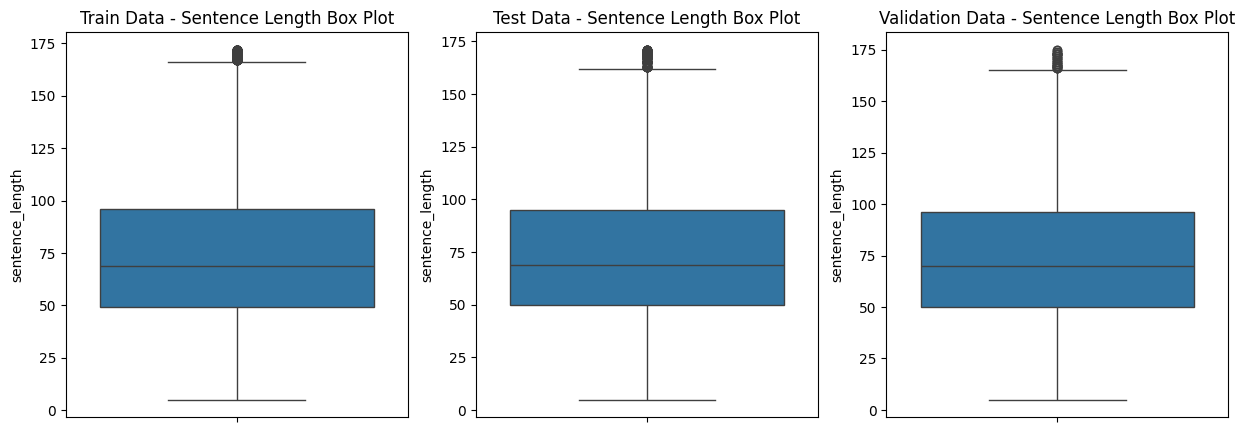

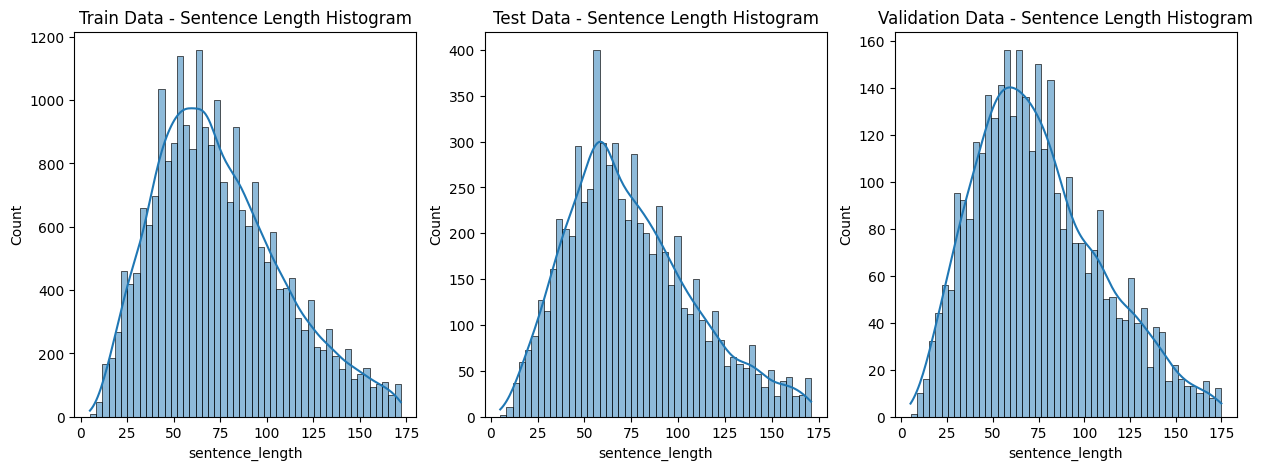


Train Data Sentence Length Statistics:
count    23800.000000
mean        74.340126
std         33.965188
min          5.000000
25%         49.000000
50%         69.000000
75%         96.000000
max        172.000000
Name: sentence_length, dtype: float64

Test Data Sentence Length Statistics:
count    6806.000000
mean       74.638995
std        33.792403
min         5.000000
25%        50.000000
50%        69.000000
75%        95.000000
max       171.000000
Name: sentence_length, dtype: float64

Validation Data Sentence Length Statistics:
count    3407.00000
mean       74.77693
std        34.30129
min         5.00000
25%        50.00000
50%        70.00000
75%        96.00000
max       175.00000
Name: sentence_length, dtype: float64


In [ ]:
def visualize_sentence_length_distribution(train_df, test_df, validation_df):
    """
    Visualizes the distribution of sentence lengths using box plots and histograms.
    """

    # Calculate sentence lengths
    train_df['sentence_length'] = train_df['Sentence'].apply(len)
    test_df['sentence_length'] = test_df['Sentence'].apply(len)
    validation_df['sentence_length'] = validation_df['Sentence'].apply(len)

    # Box Plots
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.boxplot(y=train_df['sentence_length'])
    plt.title('Train Data - Sentence Length Box Plot')

    plt.subplot(1, 3, 2)
    sns.boxplot(y=test_df['sentence_length'])
    plt.title('Test Data - Sentence Length Box Plot')

    plt.subplot(1, 3, 3)
    sns.boxplot(y=validation_df['sentence_length'])
    plt.title('Validation Data - Sentence Length Box Plot')

    plt.show()

    # Histograms
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(train_df['sentence_length'], bins=50, kde=True)
    plt.title('Train Data - Sentence Length Histogram')

    plt.subplot(1, 3, 2)
    sns.histplot(test_df['sentence_length'], bins=50, kde=True)
    plt.title('Test Data - Sentence Length Histogram')

    plt.subplot(1, 3, 3)
    sns.histplot(validation_df['sentence_length'], bins=50, kde=True)
    plt.title('Validation Data - Sentence Length Histogram')

    plt.show()

    # Describe the data.
    print("\nTrain Data Sentence Length Statistics:")
    print(train_df['sentence_length'].describe())

    print("\nTest Data Sentence Length Statistics:")
    print(test_df['sentence_length'].describe())

    print("\nValidation Data Sentence Length Statistics:")
    print(validation_df['sentence_length'].describe())

    #remove temporary column.
    train_df.drop('sentence_length', axis=1, inplace=True)
    test_df.drop('sentence_length', axis=1, inplace=True)
    validation_df.drop('sentence_length', axis=1, inplace=True)

# Assuming you have train_data, test_data, and validation_data loaded
visualize_sentence_length_distribution(train_data.copy(), test_data.copy(), validation_data.copy())

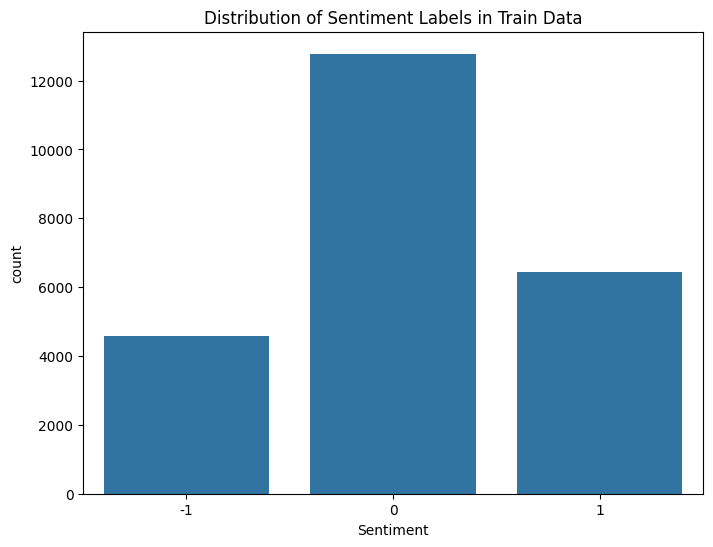

Sentiment
 0    12780
 1     6445
-1     4575
Name: count, dtype: int64


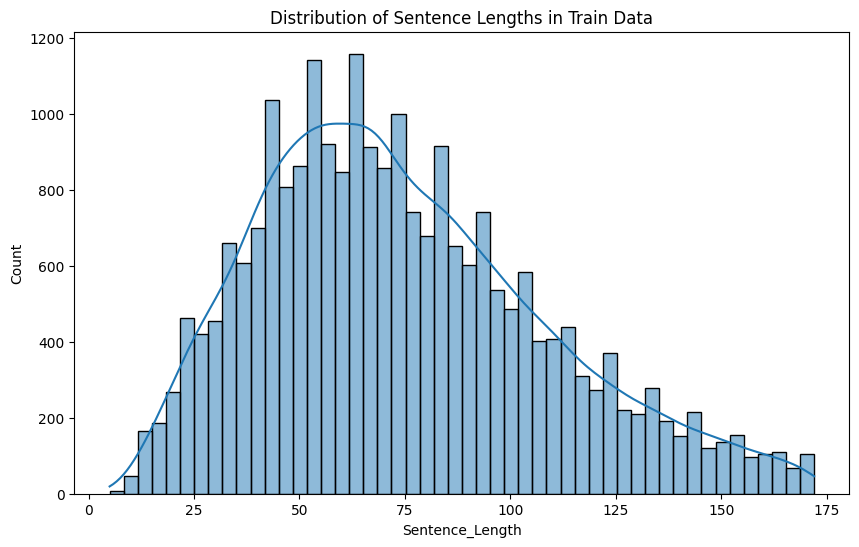

count    23800.000000
mean        74.340126
std         33.965188
min          5.000000
25%         49.000000
50%         69.000000
75%         96.000000
max        172.000000
Name: Sentence_Length, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3080 (\N{TELUGU LETTER II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3138 (\N{TELUGU VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3105 (\N{TELUGU LETTER DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-pa

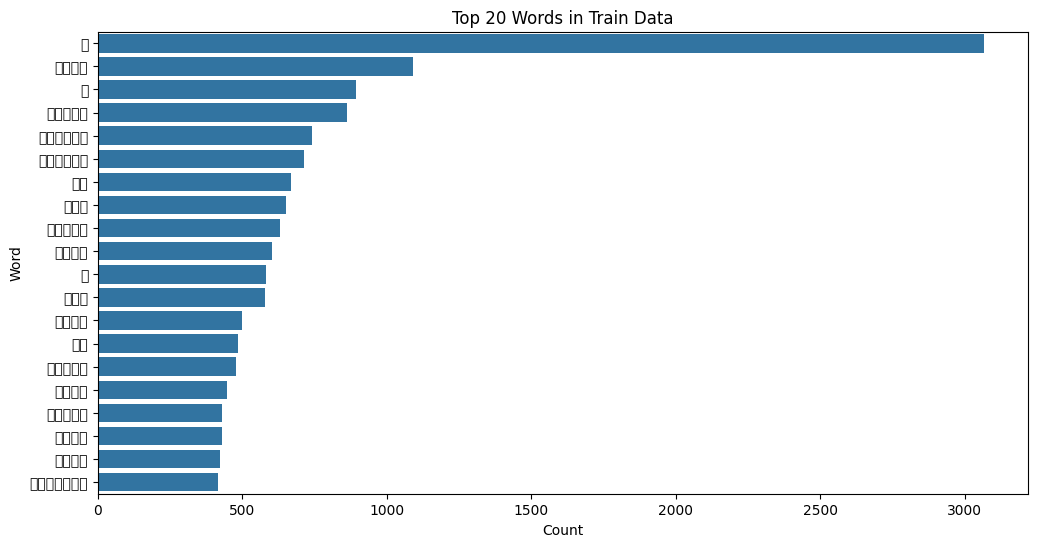

Sentence           0
Sentiment          0
Sentence_Length    0
dtype: int64
Number of duplicate sentences before removal: 285
Number of duplicate sentences after removal: 0


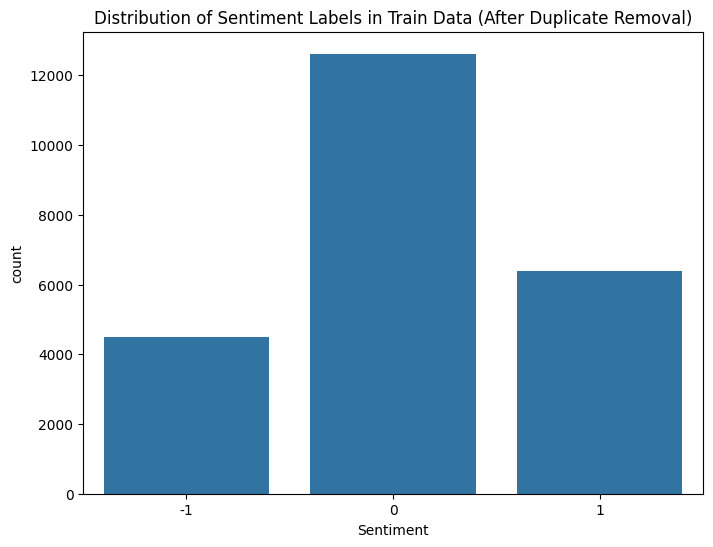

Sentiment
 0    12619
 1     6387
-1     4509
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize

# --- Load your DataFrames (train_data, test_data, validation_data) ---
# Assuming train_data is already loaded

# 1. Target Variable Analysis
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=train_data)
plt.title('Distribution of Sentiment Labels in Train Data')
plt.show()

print(train_data['Sentiment'].value_counts())

# 2. Sentence Length Analysis
train_data['Sentence_Length'] = train_data['Sentence'].apply(len)  # Character count
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Sentence_Length'], bins=50, kde=True)
plt.title('Distribution of Sentence Lengths in Train Data')
plt.show()

print(train_data['Sentence_Length'].describe())

# 3. Word Frequency Analysis
def get_top_words(text_series, top_n=20):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

top_words = get_top_words(train_data['Sentence'])
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words_df)
plt.title('Top 20 Words in Train Data')
plt.show()

# 4. Missing Values (already done)
print(train_data.isnull().sum())

# 5. Duplicate Sentences
print("Number of duplicate sentences before removal:", train_data['Sentence'].duplicated().sum())

# Drop duplicates
train_data.drop_duplicates(subset=['Sentence'], inplace=True)

print("Number of duplicate sentences after removal:", train_data['Sentence'].duplicated().sum())

# Re-run some analyses after dropping duplicates to see the effect
# For example, re-analyze the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=train_data)
plt.title('Distribution of Sentiment Labels in Train Data (After Duplicate Removal)')
plt.show()

print(train_data['Sentiment'].value_counts())

# Remember to adapt this code to your specific dataframes and analysis goals

In [ ]:
# --- Assuming you have train_data, test_data, validation_data loaded ---

# Sentiment label distribution
print("Train data sentiment distribution:")
print(train_data['Sentiment'].value_counts())

print("\nTest data sentiment distribution:")
print(test_data['Sentiment'].value_counts())

print("\nValidation data sentiment distribution:")
print(validation_data['Sentiment'].value_counts())

# Word frequency (after tokenization)
def word_frequency(df, column='Sentence'):
    all_words = []
    for sentence in df[column]:
        all_words.extend(sentence.split())  # Or use word_tokenize if you prefer
    return pd.Series(all_words).value_counts().head(20)  # Top 10 words

print("\nTop 20 words in train data:")
print(word_frequency(train_data))

Train data sentiment distribution:
Sentiment
 0    12619
 1     6387
-1     4509
Name: count, dtype: int64

Test data sentiment distribution:
Sentiment
 0    3697
 1    1842
-1    1267
Name: count, dtype: int64

Validation data sentiment distribution:
Sentiment
 0    1812
 1     919
-1     676
Name: count, dtype: int64

Top 20 words in train data:
ఈ          3038
కూడా       1084
ఆ           889
నుంచి       857
సినిమా      742
చేశారు      699
తన          663
అని         647
అయితే       624
జగన్        591
ఓ           574
ఆయన         572
ఉంది        497
లో          484
చేసిన       473
ఉన్న        442
రెండు       431
కోసం        427
తొలి        424
పరుగులు     415
Name: count, dtype: int64


In [ ]:
# Unique sentiment labels
print("\nUnique sentiment labels in train data:")
print(train_data['Sentiment'].unique())

def unique_words(df, column='Sentence'):
    all_words = []
    for sentence in df[column]:
        all_words.extend(sentence.split())
    return set(all_words)  # Use a set for unique words

print("\nNumber of unique words in train data:", len(unique_words(train_data)))


Unique sentiment labels in train data:
[ 0 -1  1]

Number of unique words in train data: 47625


**MACHINE LEARNING MODELS**

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_ml_models(X_train, y_train, X_test, y_test, feature_names=None):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500, n_jobs=-1, random_state=42),
        "Linear SVM (SGD)": SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, tol=1e-3, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
    }

    for name, model in models.items():
        print(f"\n\033[1m=== Training {name} ===\033[0m")

        # Train model
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_test)
        print("\n\033[1mClassification Report:\033[0m")
        print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
        print(f"\033[1mAccuracy:\033[0m {accuracy_score(y_test, y_pred):.4f}")

        # Confusion Matrix
        plt.figure(figsize=(6,4))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Neutral', 'Positive'],
                   yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Feature Importance (for interpretable models)
        if hasattr(model, 'coef_') and feature_names is not None:
            print("\n\033[1mTop Predictive Features:\033[0m")
            coef = model.coef_
            for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
                top_features = sorted(zip(feature_names, coef[i]),
                                   key=lambda x: abs(x[1]), reverse=True)[:10]
                print(f"\n\033[4m{label} Sentiment:\033[0m")
                for feat, weight in top_features:
                    print(f"{feat}: {weight:.4f}")

    print("\n\033[1;32mML Model Training Completed!\033[0m")

# Usage
# train_ml_models(X_train_scaled, y_train, X_test_scaled, y_test, feature_names=vectorizer.get_feature_names_out())

**DEEP LEARNING MODELS**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def train_dl_models(train_texts, train_labels, test_texts, test_labels,
                   max_words=10000, max_len=100, embedding_dim=128):
    print("\n\033[1m=== Preparing Data for Deep Learning Models ===\033[0m")

    # Tokenization
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    # Convert texts to sequences
    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_test_seq = tokenizer.texts_to_sequences(test_texts)

    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

    # Convert labels to categorical
    y_train_cat = tf.keras.utils.to_categorical(train_labels + 1)  # -1,0,1 -> 0,1,2
    y_test_cat = tf.keras.utils.to_categorical(test_labels + 1)

    # Model builder functions
    def build_lstm():
        model = Sequential([
            Embedding(max_words, embedding_dim, input_length=max_len),
            LSTM(64, dropout=0.2, recurrent_dropout=0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(3, activation='softmax')
        ])
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        return model

    def build_rnn():
        model = Sequential([
            Embedding(max_words, embedding_dim, input_length=max_len),
            SimpleRNN(64, dropout=0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(3, activation='softmax')
        ])
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        return model

    # Train and evaluate function
    def train_and_evaluate(model, name):
        print(f"\n\033[1m=== Training {name} Model ===\033[0m")
        history = model.fit(X_train_pad, y_train_cat,
                          epochs=5,
                          batch_size=64,
                          validation_data=(X_test_pad, y_test_cat),
                          verbose=1)

        # Plot training history
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{name} Accuracy')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name} Loss')
        plt.legend()
        plt.show()

        # Evaluate
        y_pred = np.argmax(model.predict(X_test_pad), axis=1) - 1  # Convert back to -1,0,1
        print("\n\033[1mEvaluation Results:\033[0m")
        print(classification_report(test_labels, y_pred,
                                  target_names=['Negative', 'Neutral', 'Positive']))
        print(f"\033[1mAccuracy:\033[0m {accuracy_score(test_labels, y_pred):.4f}")

        return model

    # Train models
    lstm_model = train_and_evaluate(build_lstm(), "LSTM")
    rnn_model = train_and_evaluate(build_rnn(), "RNN")

    print("\n\033[1;32mDeep Learning Model Training Completed!\033[0m")
    return lstm_model, rnn_model, tokenizer

# Usage
# lstm, rnn, dl_tokenizer = train_dl_models(train_texts, y_train, test_texts, y_test)

**MODELS VISUALIZATION**

TRAINING MACHINE LEARNING MODELS

=== Training Logistic Regression ===

Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.31      0.41      1267
     Neutral       0.60      0.86      0.71      3697
    Positive       0.51      0.24      0.33      1842

    accuracy                           0.59      6806
   macro avg       0.57      0.47      0.48      6806
weighted avg       0.58      0.59      0.55      6806

Accuracy: 0.5899


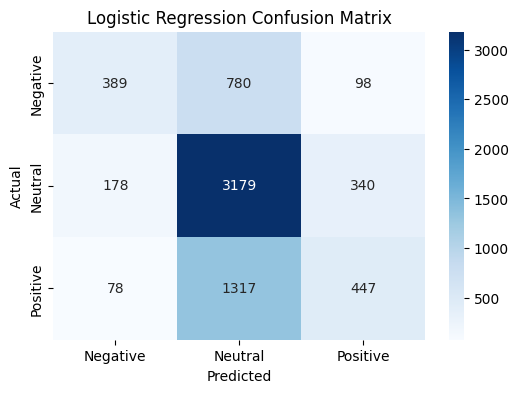


Top Predictive Features:

Negative Sentiment:
ధపడ: 2.9989
ఔటయ: 2.8742
ఫలమయ: 2.6736
ఓటమ: 2.5825
మహత: 2.2998
శపర: 2.2932
రమయ: 2.1471
చల: 2.1458
అసహన: 2.1427
ఓడ: 2.1185

Neutral Sentiment:
ధపడ: -1.9102
బయల: 1.8097
ఈద: -1.7557
తలపడన: 1.6152
జరగన: 1.6120
ఫలమయ: -1.5991
రకటన: 1.5357
అసహన: -1.5322
వరల: 1.5320
షఉట: 1.4943

Positive Sentiment:
ఏకగ: 2.1197
ఆకట: 1.9626
జయ: 1.9386
అదరగ: 1.8095
జయత: 1.7970
ఓటమ: -1.7924
ఔటయ: -1.7454
ఞతల: 1.7297
ఒద: 1.6984
ఘన: 1.6021

=== Training Linear SVM (SGD) ===

Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.20      0.31      1267
     Neutral       0.58      0.93      0.72      3697
    Positive       0.59      0.15      0.24      1842

    accuracy                           0.59      6806
   macro avg       0.60      0.43      0.42      6806
weighted avg       0.59      0.59      0.51      6806

Accuracy: 0.5858


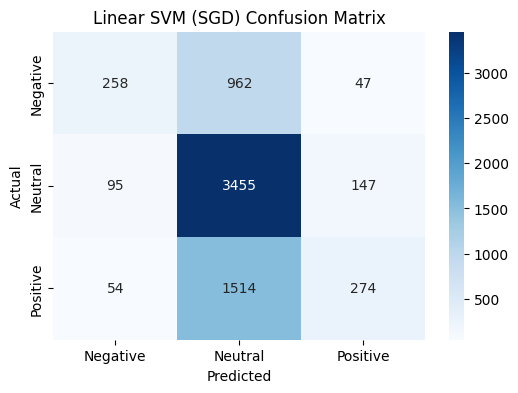


Top Predictive Features:

Negative Sentiment:
ఓటమ: 3.2746
ఔటయ: 3.2574
ధపడ: 3.0348
ఫలమయ: 2.7512
మహత: 2.7111
శపర: 2.7103
ఆగ: 2.6498
కలకల: 2.5288
అసహన: 2.4249
ఫలమ: 2.3971

Neutral Sentiment:
జయ: -3.1281
ఆకట: -2.7206
ధపడ: -2.3870
ఏకగ: -2.3172
ఘన: -2.1661
ఔటయ: -2.1599
ఓటమ: -2.1335
ఫలమయ: -2.1314
అలర: -2.1152
అగ: -2.1073

Positive Sentiment:
ఆకట: 3.5080
ఏకగ: 3.1995
జయ: 3.1952
అలర: 2.6599
ఞతల: 2.4847
అదరగ: 2.4791
జయత: 2.3869
సష: 2.2121
పతక: 2.1941
నచ: 2.0928

=== Training Naive Bayes ===

Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.08      0.15      1267
     Neutral       0.56      0.96      0.71      3697
    Positive       0.59      0.11      0.18      1842

    accuracy                           0.57      6806
   macro avg       0.62      0.39      0.35      6806
weighted avg       0.60      0.57      0.46      6806

Accuracy: 0.5680


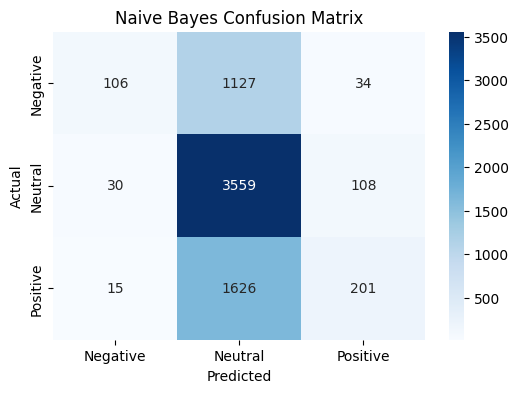


=== Training Random Forest ===

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00      1267
     Neutral       0.54      1.00      0.70      3697
    Positive       0.92      0.01      0.01      1842

    accuracy                           0.54      6806
   macro avg       0.82      0.34      0.24      6806
weighted avg       0.73      0.54      0.39      6806

Accuracy: 0.5450


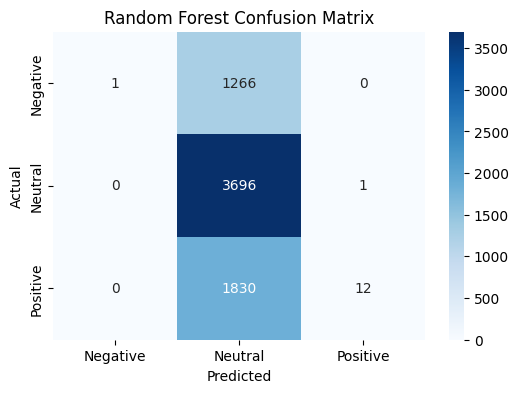


ML Model Training Completed!

TRAINING DEEP LEARNING MODELS

=== Preparing Data for Deep Learning Models ===

=== Training LSTM Model ===
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


368/368 ━━━━━━━━━━━━━━━━━━━━ 80s 202ms/step - accuracy: 0.5491 - loss: 0.9747 - val_accuracy: 0.6480 - val_loss: 0.7872
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 79s 193ms/step - accuracy: 0.7276 - loss: 0.6453 - val_accuracy: 0.6505 - val_loss: 0.8062
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 71s 192ms/step - accuracy: 0.7905 - loss: 0.5155 - val_accuracy: 0.6418 - val_loss: 0.8433
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 82s 193ms/step - accuracy: 0.8291 - loss: 0.4280 - val_accuracy: 0.6303 - val_loss: 0.9437
Epoch 5/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 71s 193ms/step - accuracy: 0.8624 - loss: 0.3492 - val_accuracy: 0.6243 - val_loss: 1.0856


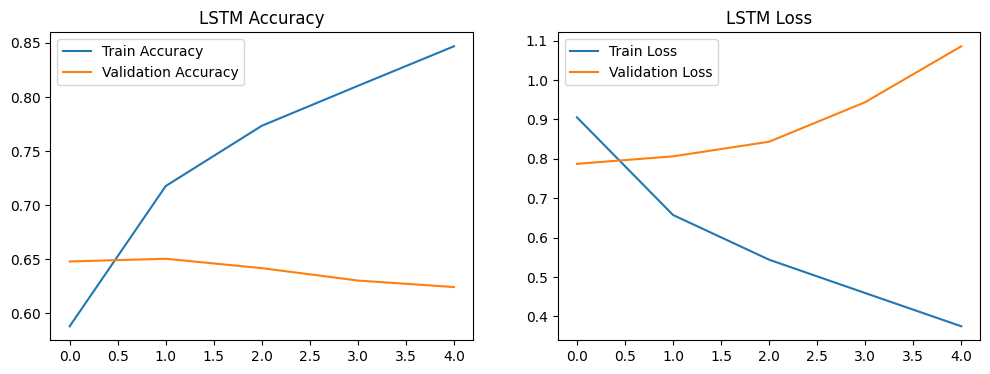

213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step

Evaluation Results:
              precision    recall  f1-score   support

    Negative       0.55      0.53      0.54      1267
     Neutral       0.68      0.73      0.70      3697
    Positive       0.55      0.48      0.51      1842

    accuracy                           0.62      6806
   macro avg       0.59      0.58      0.58      6806
weighted avg       0.62      0.62      0.62      6806

Accuracy: 0.6243

=== Training RNN Model ===
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


368/368 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.5362 - loss: 0.9909 - val_accuracy: 0.6375 - val_loss: 0.8103
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7674 - loss: 0.5817 - val_accuracy: 0.6328 - val_loss: 0.8695
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.9128 - loss: 0.2548 - val_accuracy: 0.6056 - val_loss: 1.1577
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.9540 - loss: 0.1375 - val_accuracy: 0.5945 - val_loss: 1.5264
Epoch 5/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.9544 - loss: 0.1273 - val_accuracy: 0.5823 - val_loss: 1.5451


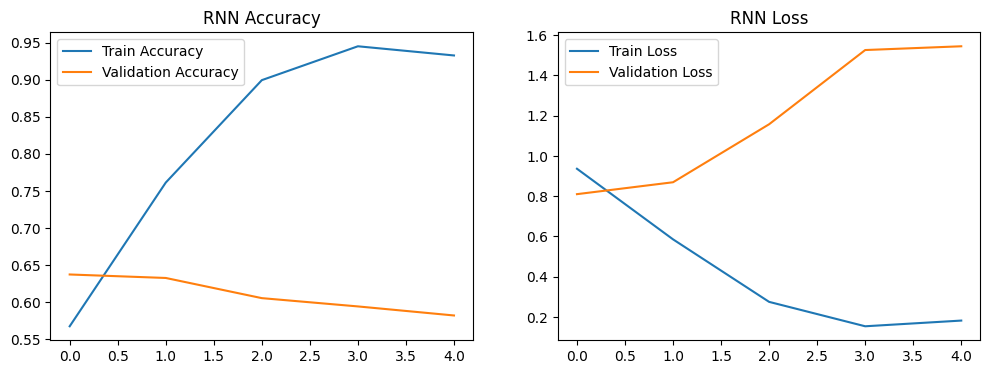

213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Evaluation Results:
              precision    recall  f1-score   support

    Negative       0.55      0.39      0.46      1267
     Neutral       0.65      0.68      0.67      3697
    Positive       0.46      0.51      0.49      1842

    accuracy                           0.58      6806
   macro avg       0.56      0.53      0.54      6806
weighted avg       0.58      0.58      0.58      6806

Accuracy: 0.5823

Deep Learning Model Training Completed!


In [ ]:
# 1. First prepare your data (assuming you have train_data and test_data DataFrames)
train_texts = train_data['Sentence'].tolist()  # Convert to list of texts
y_train = train_data['Sentiment'].values       # Convert to numpy array
test_texts = test_data['Sentence'].tolist()
y_test = test_data['Sentiment'].values

# 2. For ML models, you'll need the vectorized features
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# 3. Now you can run all models:

# A. Machine Learning Models
print("\033[1;36m" + "="*60 + "\033[0m")
print("\033[1;36mTRAINING MACHINE LEARNING MODELS\033[0m")
print("\033[1;36m" + "="*60 + "\033[0m")
train_ml_models(X_train, y_train, X_test, y_test, feature_names=vectorizer.get_feature_names_out())

# B. Deep Learning Models
print("\n\033[1;34m" + "="*60 + "\033[0m")
print("\033[1;34mTRAINING DEEP LEARNING MODELS\033[0m")
print("\033[1;34m" + "="*60 + "\033[0m")
lstm, rnn, dl_tokenizer = train_dl_models(train_texts, y_train, test_texts, y_test)

**TRANSFORMER MODEL**

In [ ]:
pip install transformers datasets sentencepiece scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

# Convert Sentiment labels to 0, 1, 2
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['Sentiment'])
test_data['label'] = label_encoder.transform(test_data['Sentiment'])
validation_data['label'] = label_encoder.transform(validation_data['Sentiment'])

# Remove original Sentiment column
train_data = train_data[['Sentence', 'label']]
test_data = test_data[['Sentence', 'label']]
validation_data = validation_data[['Sentence', 'label']]

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)
val_dataset = Dataset.from_pandas(validation_data)

In [ ]:
from transformers import AutoTokenizer

checkpoint = "ltrctelugu/bert_ltrc_telugu"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch["Sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/299 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/23515 [00:00<?, ? examples/s]

Map:   0%|          | 0/6806 [00:00<?, ? examples/s]

Map:   0%|          | 0/3407 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ltrctelugu/bert_ltrc_telugu and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_telugu_bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: at7171 (intern_test) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.017700,1.049217,0.531846,0.369307,0.282860,0.531846
2,1.012100,1.011215,0.531846,0.369307,0.282860,0.531846
3,1.003400,1.014266,0.531846,0.369307,0.282860,0.531846
4,1.005400,1.011862,0.531846,0.369307,0.282860,0.531846


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=5880, training_loss=1.010553907537136, metrics={'train_runtime': 2356.8905, 'train_samples_per_second': 39.909, 'train_steps_per_second': 2.495, 'total_flos': 6187112017873920.0, 'train_loss': 1.010553907537136, 'epoch': 4.0})

In [ ]:
eval_results = trainer.evaluate(test_dataset)
print(eval_results)

{'eval_loss': 1.0315985679626465, 'eval_accuracy': 0.5431971789597414, 'eval_f1': 0.382405021539401, 'eval_precision': 0.29506317522982134, 'eval_recall': 0.5431971789597414, 'eval_runtime': 55.592, 'eval_samples_per_second': 122.428, 'eval_steps_per_second': 7.663, 'epoch': 4.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**MODELS COMPARISION**

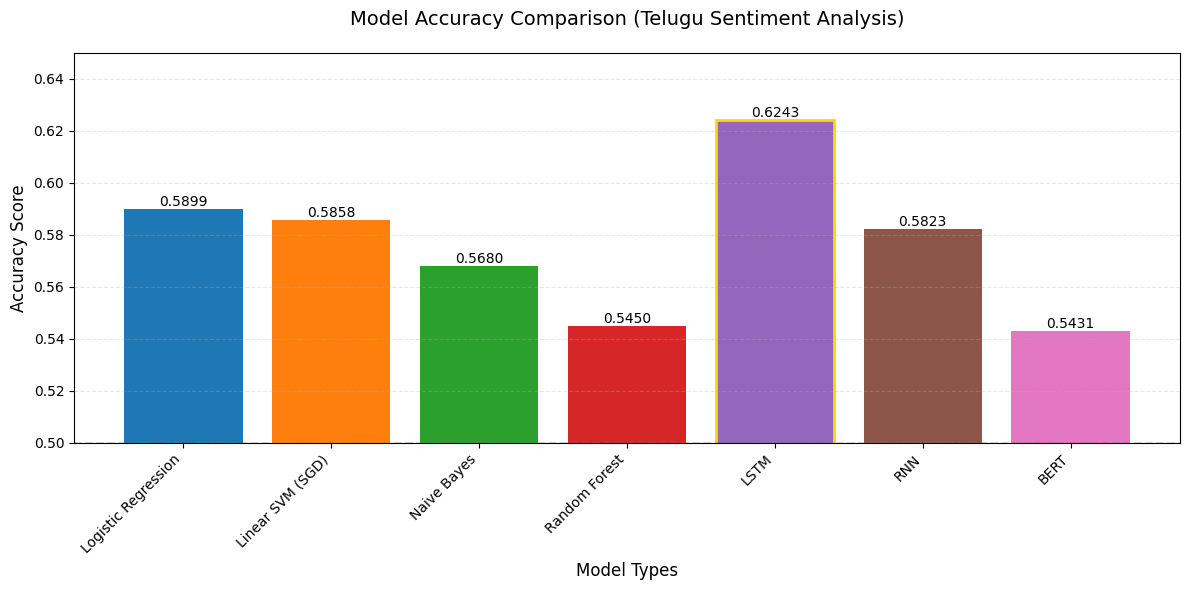

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and their accuracies
models = ['Logistic Regression', 'Linear SVM (SGD)', 'Naive Bayes',
          'Random Forest', 'LSTM', 'RNN', 'BERT']
accuracies = [0.5899, 0.5858, 0.5680, 0.5450, 0.6243, 0.5823, 0.5431]

# Create a color palette (one distinct color per model)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2']

# Create the figure and axis
plt.figure(figsize=(12, 6))
ax = plt.subplot()

# Create bars with different colors
bars = ax.bar(models, accuracies, color=colors)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.title('Model Accuracy Comparison (Telugu Sentiment Analysis)', fontsize=14, pad=20)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Model Types', fontsize=12)
plt.ylim(0.50, 0.65)  # Focus on the relevant accuracy range
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Highlight the best performing model (LSTM)
bars[models.index('LSTM')].set_edgecolor('gold')
bars[models.index('LSTM')].set_linewidth(2)

# Add a horizontal line at baseline (0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()